# Classifying Pictures of Sea Animals

Image classification is one of the most common applications of machine learning. It has been implemented in many technologies that we often use such as facial recognition for our phones. Another feature that I like to use is the “Look Up” function for photos in an iPhone which can identify the type of animal or plant in the photo. 

This technology inspired me to learn more about image classification. One of the most popular models use for image classification is the convolutional neural network. Although I have some knowledge of how they work, I have never implemented one before. In this project, I decided to build a convolutional neural network using the Tensorflow library to classify images of sea animals that I obtained from [Kaggle](https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste).

### Table of Contents
* [**1. Introduction**](#1.-Introduction)
    * [1.1 Loading Libraries](#1.1-Loading-Libraries)
    * [1.2 Loading the Data](#1.2-Loading-the-Data)
* [**2. Data Preprocessing**](#2.-Data-Preprocessing)
    * [2.1 Resizing Images](#2.1-Resizing-Images)
    * [2.2 Data Preparation](#2.2-Data-Preparation)    
* [**3. Building the CNN Model**](#3.-Building-the-CNN-Model)
    * [3.1 Initial CNN Model](#3.1-Initial-CNN-Model)
    * [3.2 Model Results](#3.2-Model-Results)
* [**4. Improving the CNN Model**](#4.-Improving-the-CNN-Model)
    * [4.1 Adding More Layers](#4.1-Adding-More-Layers)
    * [4.2 Data Augmentation](#4.2-Data-Augmentation)
    * [4.3 Hyperparameter Tuning](#4.3-Hyperparameter-Tuning) 
* [**5. Discussion**](#5.-Discussion)
    * [5.1 Comparing Results](#5.1-Comparing-Results)
    * [5.2 Overall Thoughts](#5.2-Overall-Thoughts)      
* [**6. Conclusion**](#6.-Conclusion)

## 1. Introduction

### 1.1 Loading Libraries

These are the libraries I used throughout this project.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for loading data
import os
import cv2

# Import libraries for CNN
import tensorflow as tf
from tensorflow import keras
import keras_tuner

# Import libraries for train test split and model performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### 1.2 Loading the Data

The image dataset is organized into different folders for each type of sea animal. I used the *Python OpenCV* or *cv2* to import the images, which are stored in an array of pixels, and converted them to RGB format.

In [2]:
# Obtain list of categories
CATEGORIES = [f for f in os.listdir('data/') if not f.startswith('.')]
print(f"There are {len(CATEGORIES)} classes of sea animals in the data.")

There are 19 classes of sea animals in the data.


In [3]:
# Initialize dictionary to store data
data = {}
data_size = 0

# Iterate through the categories
for category in CATEGORIES:
    
    path = os.path.join('data/', category)
    
    # Initialize empty list to store image array values
    data[category] = []
    
    img_list = os.listdir(path)
    data_size += len(img_list)
    print(f"There {category} category contains {len(img_list)} images.")
    
    for img in img_list:
        
        # Convert image to RGB and store in list
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        rgb_img = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        data[category].append(rgb_img)

print(f"There are a total of {data_size} images in the dataset.")

There Seahorse category contains 478 images.
There Sea Urchins category contains 579 images.
There Turtle_Tortoise category contains 1903 images.
There Dolphin category contains 782 images.
There Jelly Fish category contains 855 images.
There Penguin category contains 482 images.
There Squid category contains 483 images.
There Crabs category contains 499 images.
There Lobster category contains 499 images.
There Whale category contains 572 images.
There Eel category contains 497 images.
There Starfish category contains 499 images.
There Seal category contains 414 images.
There Puffers category contains 531 images.
There Sea Rays category contains 517 images.
There Sharks category contains 590 images.
There Octopus category contains 562 images.
There Corals category contains 500 images.
There Nudibranchs category contains 500 images.
There are a total of 11742 images in the dataset.


To verify that I imported the data correctly, I defined a function that plots a sample image from each category of sea animals.

In [4]:
# Define function to plot image for each category
def plot_images(data):
    fig, axes = plt.subplots(nrows = 5, ncols = 4, figsize=(18,18))

    for i, ax in enumerate(axes.flat):

        if i < len(CATEGORIES):
            ax.imshow(data[CATEGORIES[i]][0])
            ax.axis('off')
            ax.set_title(CATEGORIES[i])
        else:
            fig.delaxes(ax)
    
    plt.savefig('images/sample_images.png')

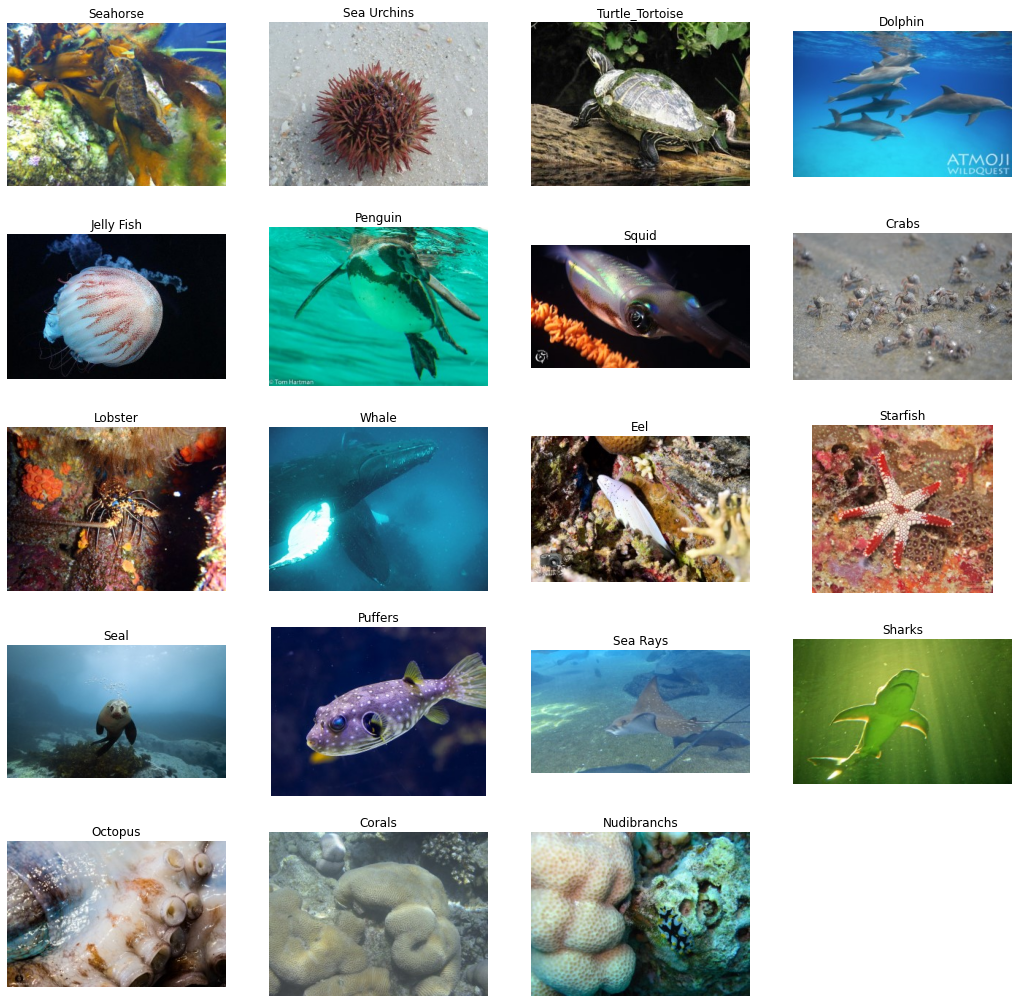

In [5]:
# Plot data
plot_images(data)

## 2. Data Preprocessing

### 2.1 Resizing Images

According to the dataset description in Kaggle, the images were resized to a resolution of (300, n) or (n, 300), where n is less than or equal to 300 pixels. Since the resulting array of pixels for each image is large, my personal computer may not be able to handle processing this large amount of data. Thus, I decided to resize the images to a smaller resolution of (64x64), which also normalizes the data by ensuring each image are the same size.

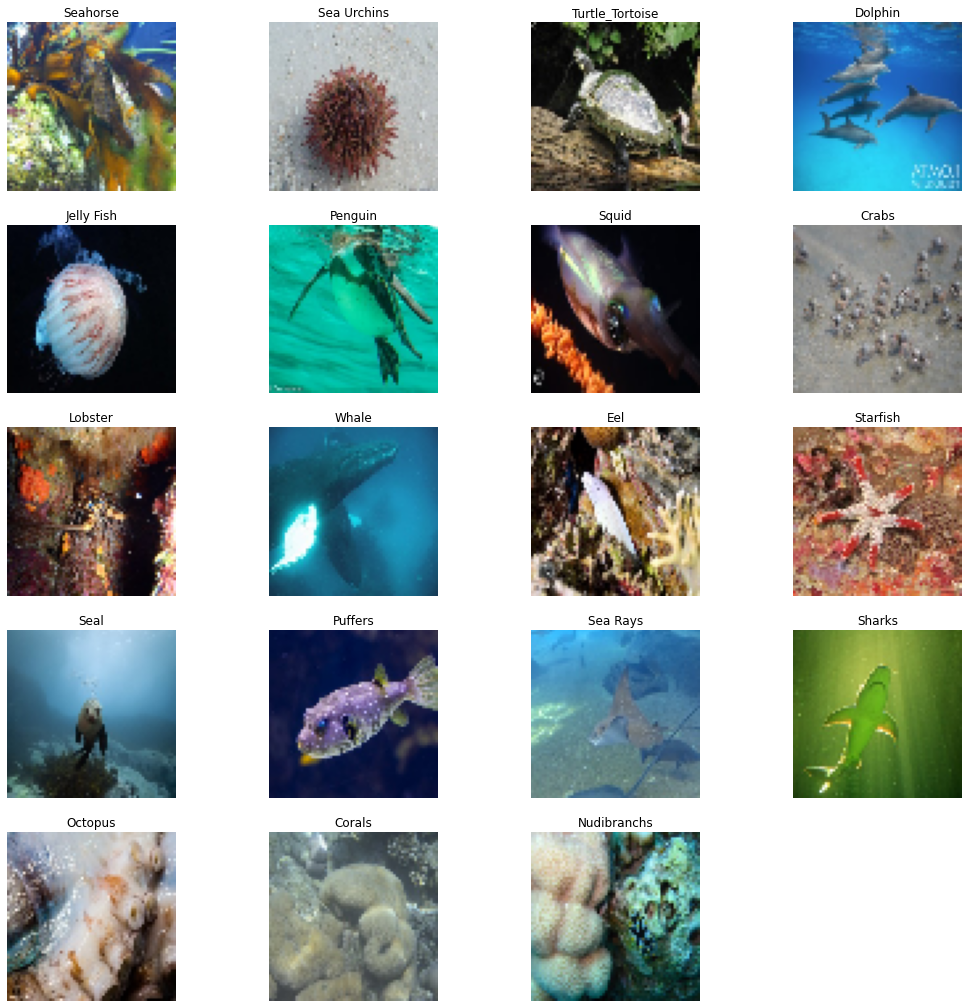

In [6]:
# Resize images to a 64x64 resolution
IMG_SIZE = 64

for category in CATEGORIES:
    data[category] = [cv2.resize(array, (IMG_SIZE, IMG_SIZE)) for array in data[category]]
    
# Plot resized images
plot_images(data)    

Compared to the original images, there does not appear to be a significant loss of detail in the pictures. Thus, I decided to proceed with this image resolution.

### 2.2 Data Preparation

Next, I need to store the data into a proper format for the CNN algorithm in the *Tensorflow* library.

I extracted the data from the dictionary and stored them into a *NumPy* array. I also created an array of class labels from 0 - 18, which corresponds to the index of each category in the list of categories defined earlier.

In [7]:
# Initialize X and y lists
X = []
y = []

# Store data in X and y lists
for category in CATEGORIES:
    for array in data[category]:
        X.append(array)
        y.append(CATEGORIES.index(category))
        
# Convert X and y to numpy arrays
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# Normalize X values
X_scaled = X / 255

# View dimension of the data
print(f"The dimension of X is {X_scaled.shape}.")

The dimension of X is (11742, 64, 64, 3).


Next, I split the data 80-20-20 into a training, validation, and testing set. The training set will be used to the train the model, the validation set will be used for model validation, and the testing set will be used to measure performance.

In [8]:
# Split training and test set
X_index = np.arange(0, X.shape[0])
train_index, test_index, y_train, y_test = train_test_split(X_index, y, test_size=0.2, random_state=101)
train_index, val_index, y_train, y_val = train_test_split(train_index, y_train, test_size=0.25, random_state=101)

# Subset data
X_train = X_scaled[train_index]
X_test = X_scaled[test_index]
X_val = X_scaled[val_index]

# Check dimensions
print(f"The dimension of the training set is {X_train.shape}")
print(f"The dimension of the testing set is {X_test.shape}")
print(f"The dimension of the validation set is {X_val.shape}")

The dimension of the training set is (7044, 64, 64, 3)
The dimension of the testing set is (2349, 64, 64, 3)
The dimension of the validation set is (2349, 64, 64, 3)


## 3. Building the CNN Model

The **convolutional neural network** or **CNN** is a type of artificial neural network that is commonly used for image classification. It involves adding a convolutional layer, which works by applying a filter over the array of input pixels and computing the convolution (aka dot product). The result is stored in a feature map where an activation function is applied to it. The results are used as inputs for the remaining layers of the neural network.

### 3.1 Initial CNN Model

I will now built an initial CNN model with the following components:

1. A single convolutional layer with:
    - 64 filters
    - (3x3) kernel size, which is the size of the filter
    - Rectified linear unit activation function
    - Input shape equal to the dimension of the data (64x64x3)
2. A flatten layer to convert the input shape to a single array
3. A single dense layer for the output layer with:
    - 19 units to represent the 19 possible classes
    - Softmax activation function
    
When selecting values for the parameters, I went with the commonly used values that I saw when researching CNN.

In [9]:
# Initial CNN model
model_init = keras.Sequential([
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=X.shape[1:]),
    keras.layers.Flatten(),
    keras.layers.Dense(len(CATEGORIES), activation='softmax')

])

Next, I compiled the model using the *adam* optimizer. Since the output labels are integers representing each category. I used the **sparse categorical crossentropy** for the loss. I also specified accuracy to be the model performance metric of choice.

In [10]:
# Compile the model
model_init.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Early stopping can be used to terminate model training when performance stops improving. Since training CNN models can be time consuming on my PC, I decided to implement early stopping with the following parameters:

- **Validation loss** as the quantity monitored
- A patience of 10 epochs, which means the training will stop after 10 epochs of no improvement. 
- Restore the best model weights from the epoch with the minimum validation loss

I also specified that the validation loss should be minimized and for the model to send an output message when it terminates training.

In [11]:
# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
                                           restore_best_weights=True)

Finally, I fit the model on the training set and used the validation set to measure performance on each epoch. I also saved the model so I can access it in the future without having to train the CNN again.

In [12]:
# Fit model
model_init.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[early_stop])

# Save model
model_init.save('models/initial_model')

Epoch 1/100
221/221 [==============================] - 13s 57ms/step - loss: 4.3992 - accuracy: 0.2077 - val_loss: 2.1161 - val_accuracy: 0.3384
Epoch 2/100
221/221 [==============================] - 12s 52ms/step - loss: 1.7656 - accuracy: 0.4733 - val_loss: 2.0450 - val_accuracy: 0.3704
Epoch 3/100
221/221 [==============================] - 12s 54ms/step - loss: 0.9797 - accuracy: 0.7363 - val_loss: 2.1980 - val_accuracy: 0.3602
Epoch 4/100
221/221 [==============================] - 11s 52ms/step - loss: 0.4823 - accuracy: 0.8897 - val_loss: 2.3532 - val_accuracy: 0.3474
Epoch 5/100
221/221 [==============================] - 11s 51ms/step - loss: 0.2621 - accuracy: 0.9414 - val_loss: 2.6983 - val_accuracy: 0.3431
Epoch 6/100
221/221 [==============================] - 11s 51ms/step - loss: 0.1849 - accuracy: 0.9657 - val_loss: 2.9092 - val_accuracy: 0.3508
Epoch 7/100
221/221 [==============================] - 11s 50ms/step - loss: 0.1054 - accuracy: 0.9822 - val_loss: 2.9215 - val_ac

Model training stopped after 12 epochs. The runtime for each epoch was generally 11 - 12 seconds.

### 3.2 Model Results

The summary of the model is shown below.

In [13]:
# Summarize model
model_init.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 19)                4674323   
Total params: 4,676,115
Trainable params: 4,676,115
Non-trainable params: 0
_________________________________________________________________


The convolutional layer has an output shape of (62x62x64) and 1,792 trainable parameters. The flatten layer converted this shape to a one-dimensional array of 246,016 values. Finally, the dense layer with the softmax activation function has an output shape of 19, which represents the array of probabilities that an image belongs to each category. 

Below, I defined a function to plot the loss and accuracy of the model for each epoch. I also a defined a function to print out the min/max loss/accuracy values.

In [14]:
# Define function to plot model loss and model accuracy
def plot_performance(model, title):
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    ax1.plot(model.history.history['loss'])
    ax1.plot(model.history.history['val_loss'])
    ax1.set_title('Model Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    ax2.plot(model.history.history['accuracy'])
    ax2.plot(model.history.history['val_accuracy'])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.savefig('images/' + title + '.png')

In [15]:
# Define function to print out the min/max loss/accuracy values
def get_best_performance_value(model):
    
    metric = ['minimum training loss', 'minimum validation loss', 
              'maximum training accuracy', 'maximum validation accuracy']
    loss_key = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
    
    for key, met, in zip(loss_key, metric):
        
        if (key == 'accuracy') | (key == 'val_accuracy'):
            best_metric = round(max(model.history.history[key]), 4) * 100
            best_metric_epoch = np.argmax(model.history.history[key]) + 1
        else:
            best_metric = round(min(model.history.history[key]), 3)
            best_metric_epoch = np.argmin(model.history.history[key]) + 1
            
        print(f"The {met} is {best_metric} and was achieved on epoch {best_metric_epoch}.")

The minimum training loss is 0.069 and was achieved on epoch 11.
The minimum validation loss is 2.045 and was achieved on epoch 2.
The maximum training accuracy is 99.46000000000001 and was achieved on epoch 12.
The maximum validation accuracy is 37.04 and was achieved on epoch 2.


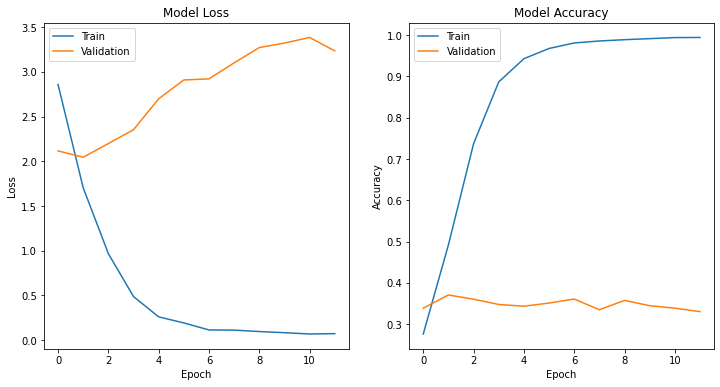

In [16]:
# Plot model performance
plot_performance(model_init, 'initial_model')

# Get min/max loss/accuracy values
get_best_performance_value(model_init)

The model performed well on the training data but not on the validation data, which indicates overfitting. The validation loss continued to increase as training loss decreased.

Based on these results, the performance of the initial CNN model is very low in classifying sea animals.

## 4. Improving the CNN Model

In this section, I attempt to improve the model's performance by adding more layers, using data augmentation, and hyperparameter tuning. 

### 4.1 Adding More Layers

First, I added more layers to the model to increase complexity. I added two new types of layers:

1. The max pooling layer involves applying a filter over the feature map and selecting the maximum element from the covered region
2. The dropout layer randomly sets the inputs to 0

I tried several combinations of these layers and made the following observations.

- Adding more dense layers generally resulted in increased training accuracy and runtime
- Adding more convolutional layers generally increased validation accuracy and lowered training accuracy
- Adding a dropout layer resulted in decreased training accuracy

In [17]:
# CNN model with more layers
model_v2 = keras.Sequential([
    
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X.shape[1:]),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(4,4)),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(CATEGORIES), activation='softmax')

])

# Compile the model
model_v2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10,
                                           restore_best_weights=True)

# Fit model
model_v2.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[early_stop])

# Save model
model_v2.save('models/improved_model')

Epoch 1/100
221/221 [==============================] - 8s 32ms/step - loss: 2.6919 - accuracy: 0.1919 - val_loss: 2.3127 - val_accuracy: 0.2648
Epoch 2/100
221/221 [==============================] - 7s 34ms/step - loss: 2.3079 - accuracy: 0.2746 - val_loss: 2.1643 - val_accuracy: 0.3142
Epoch 3/100
221/221 [==============================] - 7s 32ms/step - loss: 2.1980 - accuracy: 0.2997 - val_loss: 2.0615 - val_accuracy: 0.3563
Epoch 4/100
221/221 [==============================] - 7s 32ms/step - loss: 2.1045 - accuracy: 0.3365 - val_loss: 2.0145 - val_accuracy: 0.3708
Epoch 5/100
221/221 [==============================] - 7s 33ms/step - loss: 2.0073 - accuracy: 0.3603 - val_loss: 2.0293 - val_accuracy: 0.3504
Epoch 6/100
221/221 [==============================] - 7s 32ms/step - loss: 1.9884 - accuracy: 0.3802 - val_loss: 1.9837 - val_accuracy: 0.3848
Epoch 7/100
221/221 [==============================] - 7s 33ms/step - loss: 1.8732 - accuracy: 0.4010 - val_loss: 1.8864 - val_accuracy:

Model training stopped after 26 epochs. The runtime for each epoch was generally 7 - 8 seconds, which was faster than the initial model.

The model summary is shown below. This model has significantly less trainable parameters than the initial model (317,139 vs. 4,676,115).

In [18]:
# Summarize model
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

The minimum training loss is 0.924 and was achieved on epoch 26.
The minimum validation loss is 1.728 and was achieved on epoch 16.
The maximum training accuracy is 69.28999999999999 and was achieved on epoch 26.
The maximum validation accuracy is 46.660000000000004 and was achieved on epoch 16.


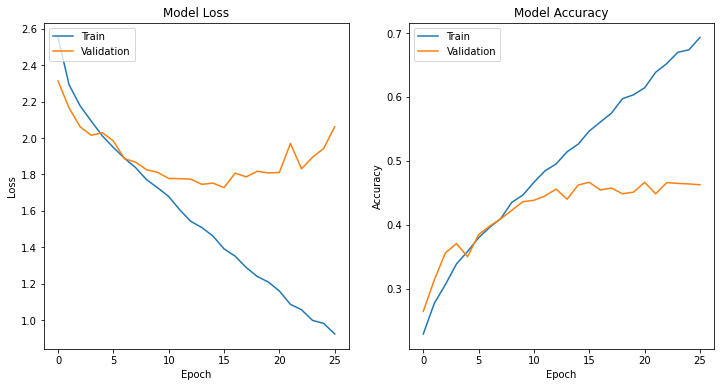

In [19]:
# Plot model performance
plot_performance(model_v2, 'improved_model_layers')

# Get min/max loss/accuracy values
get_best_performance_value(model_v2)

Adding more layers increased performance of the validation set, but the training performance is much lower. However, since the training loss is still significantly lower than the validation loss, there is still some overfitting in the model.

### 4.2 Data Augmentation

Data augmentation involves augmenting the training set by applying modifications to images such as flipping, rotating, zooming, etc.

For this model, I applied the following image modifications:
- Randomly flipping an image horizontally
- Randomly rotating an image by 20%
- Randomly zooming in by 20%

Since the previous model performed better than the initial model, I decided to use the same structure for this model.

For now, I applied basic modifications to the training set. With more research on best practice, as well as a closer examination of the training set, I might be able to apply a more specific set of image modifications.

In [20]:
# Define data augmentation
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=X.shape[1:]),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [22]:
# CNN model with more layers and data augmentation
model_v3 = keras.Sequential([
    data_augmentation,
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(4,4)),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(CATEGORIES), activation='softmax')

])

# Compile the model
model_v3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, 
                                           restore_best_weights=True)

# Fit model
model_v3.fit(X_train, y_train, epochs=100, validation_data = (X_val, y_val), callbacks=[early_stop])

# Save model
model_v3.save('models/improved_model_augmented')

Epoch 1/100
221/221 [==============================] - 10s 41ms/step - loss: 2.6971 - accuracy: 0.1914 - val_loss: 2.3463 - val_accuracy: 0.2648
Epoch 2/100
221/221 [==============================] - 9s 40ms/step - loss: 2.4181 - accuracy: 0.2537 - val_loss: 2.3227 - val_accuracy: 0.2699
Epoch 3/100
221/221 [==============================] - 8s 38ms/step - loss: 2.3004 - accuracy: 0.2771 - val_loss: 2.1019 - val_accuracy: 0.3312
Epoch 4/100
221/221 [==============================] - 8s 38ms/step - loss: 2.1759 - accuracy: 0.3127 - val_loss: 2.0692 - val_accuracy: 0.3461
Epoch 5/100
221/221 [==============================] - 8s 38ms/step - loss: 2.1249 - accuracy: 0.3366 - val_loss: 2.0338 - val_accuracy: 0.3602
Epoch 6/100
221/221 [==============================] - 9s 39ms/step - loss: 2.0687 - accuracy: 0.3435 - val_loss: 2.0326 - val_accuracy: 0.3627
Epoch 7/100
221/221 [==============================] - 9s 39ms/step - loss: 2.0817 - accuracy: 0.3280 - val_loss: 1.9713 - val_accuracy

Model training stopped after 41 epochs. The runtime for each epoch was generally 8 - 9 seconds.

The model summary is shown below. Since I used the same structure as the previous model, the resulting output shape and number of parameters are the same. 

In [23]:
# Summarize model
model_v3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

The minimum training loss is 1.56 and was achieved on epoch 41.
The minimum validation loss is 1.691 and was achieved on epoch 31.
The maximum training accuracy is 50.21 and was achieved on epoch 38.
The maximum validation accuracy is 48.620000000000005 and was achieved on epoch 38.


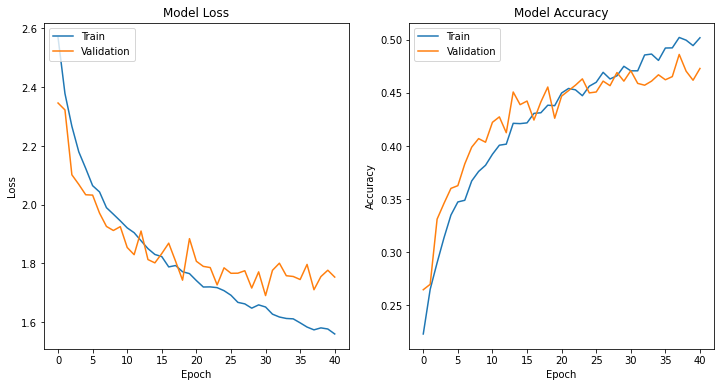

In [24]:
# Plot model performance
plot_performance(model_v3, 'improved_model_augmented')

# Get min/max loss/accuracy values
get_best_performance_value(model_v3)

Data augmentation resulted in a similar performance to the previous model when it comes to validation loss and accuracy. However, the training performance is significantly lower and is almost equal to the validation performance. 

Since the gap between the training and validation metrics are much smaller, I was able to avoid overfitting. However, it appears that with more epochs, the model might eventually start to overfit again. 

### 4.3 Hyperparameter Tuning

Hyperparameter tuning is the process of searching for optimal hyperparameters that define a model to produce the best fit and results. I will be using the RandomSearch Tuner from the Keras library to do this.

Since this can be a time consuming process that my PC may not be able to handle, I will only define a small search space with 12 trials. Each trial will run 15 epochs. The hyperparameters I will be focusing on are the number of units in my first dense layer and the learning rate. The learning rate specifies how much the weights are adjusted in the model.

I used the same model structure from [Section 4.1](#4.1-Adding-More-Layers).

In [28]:
# Store model structure into a function 
def build_model(hp):
    
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=X.shape[1:]))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3)))
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(4,4)))
    
    model.add(keras.layers.Flatten())
    
    # Dense layer hyperparameter
    model.add(keras.layers.Dense(
        units=hp.Int("units", min_value=256, max_value=512, step=128), activation='relu'))
    
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(len(CATEGORIES), activation='softmax'))
    
    # Learning rate hyperparameter
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

In [27]:
# Run the random search to run trials
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=12)
tuner.search(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

# Extract best model from the grid search
best_model = tuner.get_best_models()[0]

# Summarize model
best_model.summary()

Trial 12 Complete [00h 02m 05s]
val_loss: 1.7219401597976685

Best val_loss So Far: 1.69730544090271
Total elapsed time: 00h 24m 43s
INFO:tensorflow:Oracle triggered exit
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)    

The 12 trials took 24 minutes and 43 seconds to complete. The model that produced the lowest validation loss of 1.697 had a dense layer of 512 units and a learning rate of 0.00036742. It also had 612,307 trainable parameters. 

Since the validation loss is about the same as the previous models, hyperparameter tuning with the defined search space did not improve the model any further. Having an increased number of epochs may have increased performance slightly.

## 5. Discussion

### 5.1 Comparing Results

I will now evaluate the performance of each model on the testing set and compare them.

In [29]:
# Define list of models
models = [model_init, model_v2, model_v3, best_model]
model_names = ["Initial Model", "Improved CNN Model", "Data Augmentation", "Hyperparameter Tuning"]

# Obtain list of loss and accuracy and store in a dataframe
model_loss = [model.evaluate(X_test, y_test, verbose=0)[0] for model in models]
model_accuracy = [model.evaluate(X_test, y_test, verbose=0)[1] for model in models]

df_metrics = pd.DataFrame(list(zip(model_names, model_loss, model_accuracy)), columns=['name', 'loss', 'accuracy'])
df_metrics

,name,loss,accuracy
0,Initial Model,2.058940,0.383567
1,Improved CNN Model,1.746997,0.459770
2,Data Augmentation,1.681862,0.484461
3,Hyperparameter Tuning,1.721245,0.460622


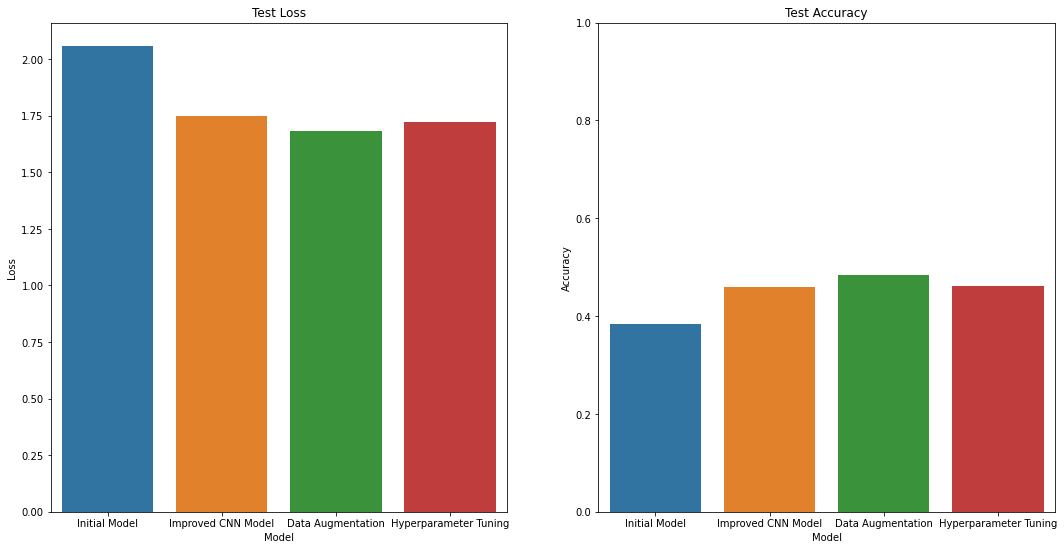

In [30]:
# Plot loss and accuracy
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 9))

sns.barplot(x ='name', y ='loss', data = df_metrics, ax=ax1)
ax1.set_title('Test Loss')
ax1.set_xlabel('Model')
ax1.set_ylabel('Loss')


sns.barplot(x ='name', y ='accuracy', data = df_metrics, ax=ax2)
ax2.set_title('Test Accuracy')
ax2.set_xlabel('Model')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)

plt.savefig('images/model_results_plot.png')

Based on these graphs, the model that utilized data augmentation performed the best with an accuracy of 48.4% while the initial model performed the worst with a 38.4% accuracy. This is a **26% increase in performance**. However, the difference among the accuracies of the three improved models are almost negligible with values ranging from 46.0% - 48.4%. 

Next, I defined a function that outputs the classification report for each model and a heatmap of the confusion matrix. 

In [31]:
# Define function to output classification report and confusion matrix
def get_cr_cf(model, title):
    
    # Get predictions
    predictions = model.predict(X_test)
    y_preds = [np.argmax(element) for element in predictions]
    
    # Map integer labels to categories
    y_preds = np.array([CATEGORIES[index] for index in y_preds])
    y_labels = np.array([CATEGORIES[index] for index in y_test])
    
    # Print classification report
    print(classification_report(y_labels, y_preds))
    
    # Plot confusion matrix
    plt.figure(figsize = (12, 9))
    cf = confusion_matrix(y_labels, y_preds)
    
    sns.heatmap(cf, cmap='crest', annot=True, xticklabels=sorted(CATEGORIES), yticklabels=sorted(CATEGORIES), fmt='g')
    plt.savefig('images/' + title + '_confusion_matrix.png')
    

                 precision    recall  f1-score   support

         Corals       0.28      0.22      0.24        93
          Crabs       0.76      0.38      0.51       110
        Dolphin       0.33      0.53      0.40       153
            Eel       0.22      0.13      0.17        90
     Jelly Fish       0.48      0.73      0.58       161
        Lobster       0.23      0.20      0.21        96
    Nudibranchs       0.48      0.15      0.23        98
        Octopus       0.15      0.04      0.06       106
        Penguin       0.35      0.32      0.34        93
        Puffers       0.22      0.09      0.13       108
       Sea Rays       0.32      0.07      0.11       130
    Sea Urchins       0.65      0.57      0.61       115
       Seahorse       0.56      0.05      0.09        98
           Seal       0.30      0.16      0.21        81
         Sharks       0.35      0.28      0.31       118
          Squid       0.26      0.11      0.15       102
       Starfish       0.42    

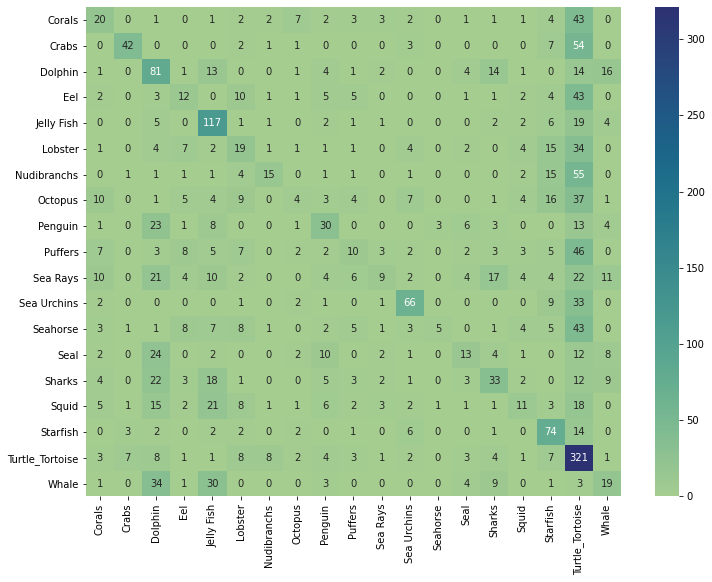

In [32]:
# Get classification report and confusion matrix for the initial model
get_cr_cf(model_init, 'initial_model')

When it comes to the F1-score, which is the harmonic mean of precision and recall, the initial model performed best in classifying jellyfish and crabs. When it comes to recall or true positive rate, this model performed the best at classifying jelly fish and sea urchins. 

                 precision    recall  f1-score   support

         Corals       0.37      0.49      0.42        93
          Crabs       0.72      0.55      0.62       110
        Dolphin       0.37      0.64      0.47       153
            Eel       0.20      0.20      0.20        90
     Jelly Fish       0.56      0.75      0.64       161
        Lobster       0.35      0.34      0.35        96
    Nudibranchs       0.46      0.29      0.35        98
        Octopus       0.22      0.15      0.18       106
        Penguin       0.38      0.51      0.43        93
        Puffers       0.25      0.20      0.23       108
       Sea Rays       0.24      0.09      0.13       130
    Sea Urchins       0.72      0.70      0.71       115
       Seahorse       0.30      0.26      0.28        98
           Seal       0.38      0.31      0.34        81
         Sharks       0.31      0.43      0.36       118
          Squid       0.44      0.17      0.24       102
       Starfish       0.50    

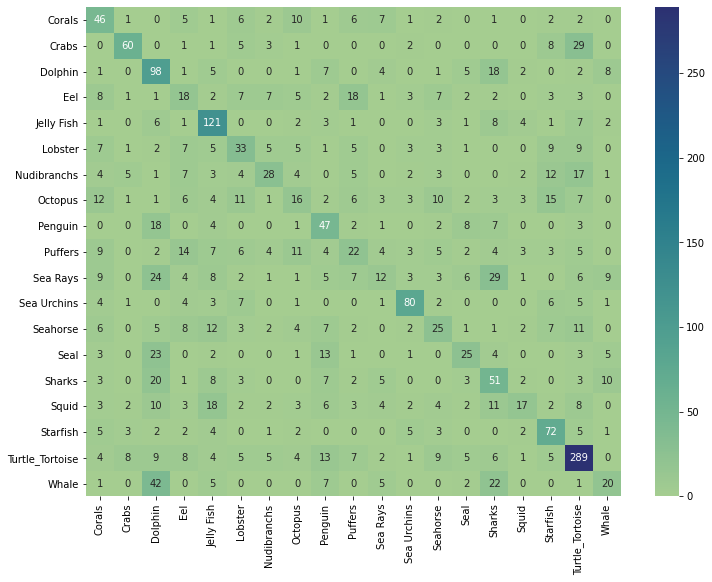

In [33]:
# Get classification report and confusion matrix for the improved model (layers)
get_cr_cf(model_v2, 'model_layers')

The improved model performed well in classifying turtles/tortoises, jellyfish, sea urchins, and crabs. It also has a pretty good recall for turtles/tortoises and sea urchins.

                 precision    recall  f1-score   support

         Corals       0.26      0.56      0.36        93
          Crabs       0.70      0.75      0.72       110
        Dolphin       0.44      0.48      0.46       153
            Eel       0.22      0.24      0.23        90
     Jelly Fish       0.63      0.70      0.66       161
        Lobster       0.33      0.29      0.31        96
    Nudibranchs       0.35      0.45      0.39        98
        Octopus       0.19      0.05      0.08       106
        Penguin       0.45      0.58      0.50        93
        Puffers       0.27      0.08      0.13       108
       Sea Rays       0.10      0.01      0.01       130
    Sea Urchins       0.56      0.75      0.64       115
       Seahorse       0.45      0.28      0.34        98
           Seal       0.47      0.35      0.40        81
         Sharks       0.31      0.37      0.34       118
          Squid       0.62      0.25      0.35       102
       Starfish       0.62    

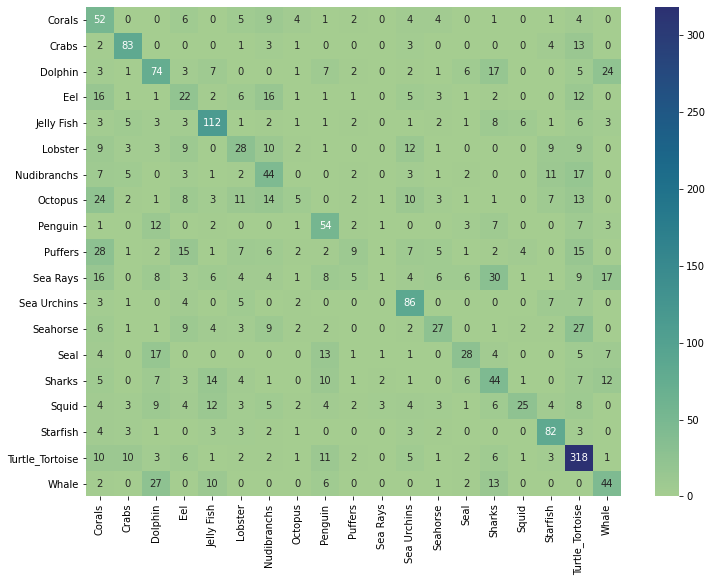

In [34]:
# Get classification report and confusion matrix for the improved model (data augmentation)
get_cr_cf(model_v3, 'model_augment')

The model utilizing the data augmentation has almost the same results as the previous model, which used the same structure. 

                 precision    recall  f1-score   support

         Corals       0.50      0.32      0.39        93
          Crabs       0.72      0.66      0.69       110
        Dolphin       0.40      0.57      0.47       153
            Eel       0.19      0.20      0.20        90
     Jelly Fish       0.53      0.76      0.62       161
        Lobster       0.35      0.35      0.35        96
    Nudibranchs       0.32      0.43      0.37        98
        Octopus       0.16      0.18      0.17       106
        Penguin       0.36      0.60      0.45        93
        Puffers       0.27      0.15      0.19       108
       Sea Rays       0.30      0.20      0.24       130
    Sea Urchins       0.74      0.63      0.69       115
       Seahorse       0.32      0.37      0.34        98
           Seal       0.42      0.26      0.32        81
         Sharks       0.44      0.27      0.34       118
          Squid       0.41      0.11      0.17       102
       Starfish       0.64    

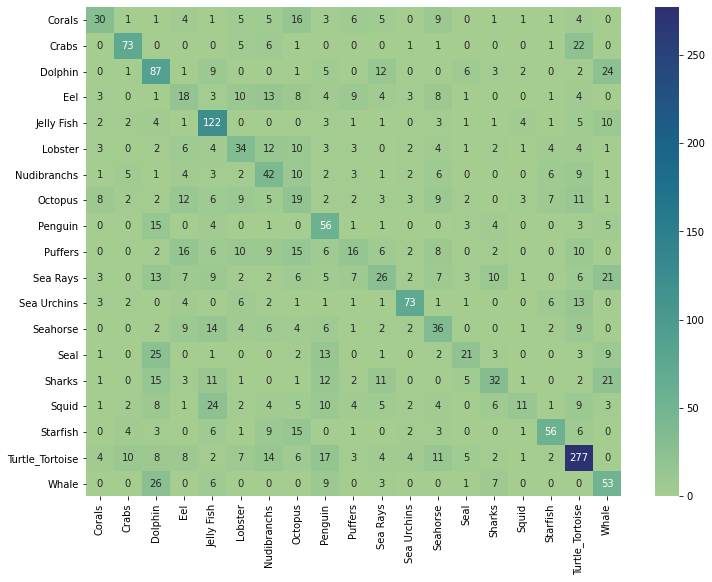

In [35]:
# Get classification report and confusion matrix for the improved model (hyparameter tuning)
get_cr_cf(best_model, 'model_tune')

The model from the hyperparameter tuning performed the best at classifying turtle/tortoises, sea urchins, and jellyfish. It also has great recall for turtle/tortoise, jellyfish, and whale.

### 5.2 Overall Thoughts

The performance of all my models were relatively poor. However, I was able to increase the performance of my initial model by 26% by increasing model complexity and applying data augmentation. 

There are many reasons why my models performed the way that they did:
1. **Lack of knowledge about CNNs**. Since this project was meant to be a self-learning introduction to CNNs, it’s possible that I selected suboptimal choices when defining the models. With more knowledge and experience, I might be able to make a more educated selection of hyperparameters and layers.
2. **The training data**. The training data may not be sufficient to differentiate between the sea animals. Thus, a closer examination of the dataset might be helpful for making decisions such as whether to use color or not, and how to improve data augmentation. Having more appropriate data will also be beneficial.
3. **Using the wrong tools**. Other algorithms and libraries might be better suited for this data than the ones I used. A different search algorithm for hyperparameter tuning could potentially produce a better result.
4. **Lack of access to a high-performance computer**. Since I am running this on my personal computer, I do not have the capabilities to run complex, deep models.

Despite these issues, I still think this was a great self-learning experience to introduce myself to CNN’s. Since I saved my models, I can revisit this project in the future with more knowledge to see if I can improve it even further. 


## 6. Conclusion

In this project, I was able to learn more about convolutional neural networks and implement the algorithm to classify images of sea animals. Although the performance was much lower than I had hoped, it was still a great learning experience for the algorithm. With the models saved, I might be able to improve the models with more knowledge and access to a better machine.  